In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import *
import pickle as pkl
from torchvision import datasets, transforms
import transform_wrappers
import visualize as viz
torch.manual_seed(42)
np.random.seed(42)

In [2]:
sys.path.append('../../..')
# from hierarchical_dnn_interpretations.acd.scores import cd as acd
from acd_wooseok.acd.scores import cd, score_funcs
from knockout_fft import *
import warnings
warnings.filterwarnings("ignore")

# scores in fft space

In [77]:
# load args
args = dset.get_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size,
                                           args.test_batch_size,
                                           device,
                                           return_indices=False)

# true band centers model is trained with
true_band_centers = np.linspace(0.15, 0.85, 20)
band_idx = 1
# test_knockout_models(test_loader, args, true_band_centers)

In [78]:
# transform
t = lambda x: torch.rfft(x, 2, onesided=False)
transform_i = transform_wrappers.modularize(lambda x: torch.irfft(x, 2, onesided=False))

# load model
model = Net2c().to(device)
model.load_state_dict(torch.load(opj('models/freq','net2c_' + str(band_idx) + '.pth'), map_location=device))
model = model.eval()
model_t = transform_wrappers.Net_with_transform(model=model, transform=transform_i)

In [79]:
im, _ = iter(test_loader).next()
im = im[0:1]
im_fft = t(im)

# get interp scores
results = get_attributions(im_fft.to(device), model_t)

In [80]:
freq_arr = fftfreq(n=28)
freq_arr /= np.max(np.abs(freq_arr))

band_center = true_band_centers[band_idx]
band_width = 0.1
mask_bandpass = np.ones((28,28))
for r in range(28):
    for c in range(28):
        dist = np.sqrt(freq_arr[r]**2 + freq_arr[c]**2)
        if dist > band_center - band_width / 2 and dist < band_center + band_width / 2:
            mask_bandpass[r, c] = 0

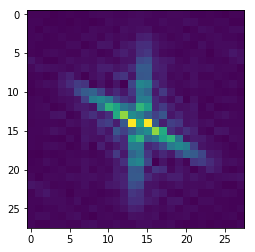

In [81]:
plt.imshow(fftshift(mag(torch.rfft(im.squeeze(), 2, onesided=False))))

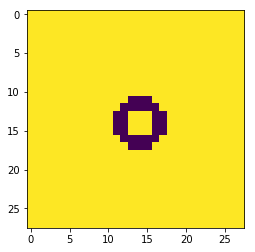

In [82]:
plt.imshow(fftshift(mask_bandpass))
plt.show()

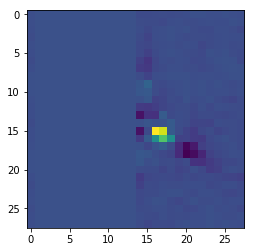

In [83]:
plt.imshow(fftshift(results['CD']))
plt.show()

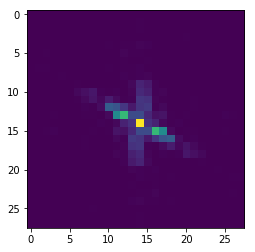

In [84]:
plt.imshow(fftshift(results['IG']))
plt.show()

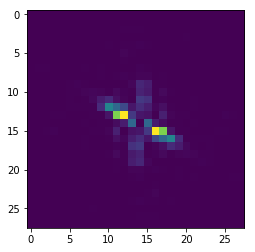

In [85]:
plt.imshow(fftshift(results['DeepLift']))
plt.show()

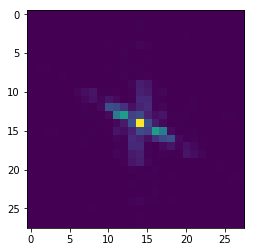

In [86]:
plt.imshow(fftshift(results['SHAP']))
plt.show()

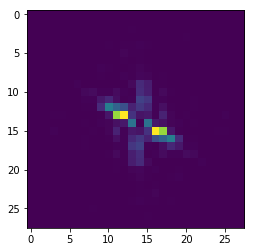

In [87]:
plt.imshow(fftshift(results['InputXGradient']))
plt.show()